In [6]:
from PIL import Image as IMG

from matplotlib import pyplot as plt
import numpy as np

import os
import sys
import collections
import struct

import cv2

from skimage.transform import FundamentalMatrixTransform

In [7]:
"""
Preuzeto sa https://www.eth3d.net/documentation
Pomocna skripta za ucitavanje podataka o kameri i slika
"""
CameraModel = collections.namedtuple(
    "CameraModel", ["model_id", "model_name", "num_params"])
Camera = collections.namedtuple(
    "Camera", ["id", "model", "width", "height", "params"])
BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])
Point3D = collections.namedtuple(
    "Point3D", ["id", "xyz", "rgb", "error", "image_ids", "point2D_idxs"])

CAMERA_MODELS = {
    CameraModel(model_id=0, model_name="SIMPLE_PINHOLE", num_params=3),
    CameraModel(model_id=1, model_name="PINHOLE", num_params=4),
    CameraModel(model_id=2, model_name="SIMPLE_RADIAL", num_params=4),
    CameraModel(model_id=3, model_name="RADIAL", num_params=5),
    CameraModel(model_id=4, model_name="OPENCV", num_params=8),
    CameraModel(model_id=5, model_name="OPENCV_FISHEYE", num_params=8),
    CameraModel(model_id=6, model_name="FULL_OPENCV", num_params=12),
    CameraModel(model_id=7, model_name="FOV", num_params=5),
    CameraModel(model_id=8, model_name="SIMPLE_RADIAL_FISHEYE", num_params=4),
    CameraModel(model_id=9, model_name="RADIAL_FISHEYE", num_params=5),
    CameraModel(model_id=10, model_name="THIN_PRISM_FISHEYE", num_params=12)
}
CAMERA_MODEL_IDS = dict([(camera_model.model_id, camera_model) for camera_model in CAMERA_MODELS])

class Image(BaseImage):
    def qvec2rotmat(self):
        return qvec2rotmat(self.qvec)

def read_cameras_text(path):
    cameras = {}
    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                elems = line.split()
                camera_id = int(elems[0])
                model = elems[1]
                width = int(elems[2])
                height = int(elems[3])
                params = np.array(tuple(map(float, elems[4:])))
                cameras[camera_id] = Camera(id=camera_id, model=model,
                                            width=width, height=height,
                                            params=params)
    return cameras

def read_images_text(path):
    images = {}
    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                elems = line.split()
                image_id = int(elems[0])
                qvec = np.array(tuple(map(float, elems[1:5])))
                tvec = np.array(tuple(map(float, elems[5:8])))
                camera_id = int(elems[8])
                image_name = elems[9]
                elems = fid.readline().split()
                xys = np.column_stack([tuple(map(float, elems[0::3])),
                                       tuple(map(float, elems[1::3]))])
                point3D_ids = np.array(tuple(map(int, elems[2::3])))
                images[image_id] = Image(
                    id=image_id, qvec=qvec, tvec=tvec,
                    camera_id=camera_id, name=image_name,
                    xys=xys, point3D_ids=point3D_ids)
    return images

def read_points3D_text(path):
    points3D = {}
    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                elems = line.split()
                point3D_id = int(elems[0])
                xyz = np.array(tuple(map(float, elems[1:4])))
                rgb = np.array(tuple(map(int, elems[4:7])))
                error = float(elems[7])
                image_ids = np.array(tuple(map(int, elems[8::2])))
                point2D_idxs = np.array(tuple(map(int, elems[9::2])))
                points3D[point3D_id] = Point3D(id=point3D_id, xyz=xyz, rgb=rgb,
                                               error=error, image_ids=image_ids,
                                               point2D_idxs=point2D_idxs)
    return points3D

def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])


def rotmat2qvec(R):
    Rxx, Ryx, Rzx, Rxy, Ryy, Rzy, Rxz, Ryz, Rzz = R.flat
    K = np.array([
        [Rxx - Ryy - Rzz, 0, 0, 0],
        [Ryx + Rxy, Ryy - Rxx - Rzz, 0, 0],
        [Rzx + Rxz, Rzy + Ryz, Rzz - Rxx - Ryy, 0],
        [Ryz - Rzy, Rzx - Rxz, Rxy - Ryx, Rxx + Ryy + Rzz]]) / 3.0
    eigvals, eigvecs = np.linalg.eigh(K)
    qvec = eigvecs[[3, 0, 1, 2], np.argmax(eigvals)]
    if qvec[0] < 0:
        qvec *= -1
    return qvec


def read_model(path):
    cameras = read_cameras_text(os.path.join(path, "cameras.txt"))
    images = read_images_text(os.path.join(path, "images.txt"))
    points3D = read_points3D_text(os.path.join(path, "points3D.txt"))
    return cameras, images, points3D

In [180]:
folder = 'multi_view_training_dslr_jpg/'
image_set = 'courtyard/'
info_folder = folder + image_set + 'dslr_calibration_jpg/'

In [181]:

camera_info, images_info, points_info = read_model(info_folder)
# Loading images in a list
images = list(list())
for dirName, subdirList, fileList in os.walk(folder + image_set + 'images/dslr_images/'):
    for fname in fileList:
        images.append(['dslr_images/' + fname, cv2.imread(dirName + fname)])#IMG.open(dirName + fname)])
        break # currently testing on one image

In [10]:
"""
"Camera", ["id", "model", "width", "height", "params"]
"Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"]
"Point3D", ["id", "xyz", "rgb", "error", "image_ids", "point2D_idxs"]
"""
print()

# Loading distortion model for picture from camera

In [185]:
image = images[0]

# Fiding data about picture
for i in images_info:
    if images_info[i].name == image[0]:
        image_data = images_info[i]
        break

# Finding camera for given picture stored in camera_data
for i in camera_info:
    if camera_info[i].id == image_data.camera_id:
        camera_data = camera_info[i]

# Loading camera params
fx, fy, cx, cy, k1, k2, p1, p2, k3, k4, sx1, sx2 = camera_data.params    

dist_coeff = np.array([k1,k2,p1,p2,k3])#,k4])#,  sx1, sy1 ])
dist_coeff2 = np.array([k1,k2,p1,p2,k3, k4,  sx1, sy1 ])
cam_matx = np.array([[fx,0,cx],[0,fy,cy],[0,0,1]])
Rot = np.array(image_data.qvec)
Tran = np.array(image_data.tvec)

# cv2.new

In [125]:
print("Current picture is \'%s\'" % image[0])

Current picture is 'dslr_images/DSC_0311.JPG'


In [126]:
# R = np.asmatrix([[Rot[2],Rot[3],0], [Rot[1],Rot[2],0],[0,0,1]]) # not correct

In [127]:
img = image[1]
h,  w = img.shape[:2]
#implemet?
new_camera_mtx, roi=cv2.getOptimalNewCameraMatrix(cam_matx,dist_coeff,(w,h),1,(w,h))
print(new_camera_mtx)
print(cam_matx)

[[3.95848706e+03 0.00000000e+00 3.03367162e+03]
 [0.00000000e+00 3.67414819e+03 2.01179569e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[3.40958e+03 0.00000e+00 3.03634e+03]
 [0.00000e+00 3.40944e+03 2.01330e+03]
 [0.00000e+00 0.00000e+00 1.00000e+00]]


In [194]:
# Calcualting for comparison
mapx, mapy = cv2.initUndistortRectifyMap(cam_matx, dist_coeff2, None, None, (w,h), cv2.CV_32FC1)

In [196]:
def initUndistortRectifyMap_pinhole(camMat, dCoeff, size):
    """
    return map_x, map_y
    """
    
    w, h = size
    
    # making new camera matrix, but alpha caluclations are missing
    newCMat = camMat
    newCMat[0][2] = (w-1)*0.5
    newCMat[1][2] = (h-1)*0.5
    
    # u0 = cx , v0  = cy
    fx = camMat[0][0]
    fy = camMat[1][1]
    
    cx = camMat[0][2]
    cy = camMat[1][2]
    
    
    
    k1, k2, p1, p2, k3 = dCoeff
    k4 = k5 = k6 = 0
        
    mapx = np.ones((w,h))
    mapy = np.ones((w,h))
    
    mapx = mapx.astype('float32')
    mapy = mapy.astype('float32')
    

    for i in range(0,w):
        u = i
        x = (u - newCMat[0][2]) / newCMat[0][0]
        x2 = x*x
        for j in range(0,h):
            v = j

            y = (v - newCMat[1][2]) / newCMat[1][1]

            #Rot matrix currently identity
#             [x, y, w] = np.dot(np.linalg.inv([[1,0,0],[0,1,0],[0,0,1]]),np.transpose([x,y,1]))

            y2 = y*y;
            r2 = x2 + y2
            _2xy = 2*x*y;

            kr = (1 + ((k3*r2 + k2)*r2 + k1)*r2)/(1 + ((k6*r2 + k5)*r2 + k4)*r2);
            
            u = fx*(x*kr + p1*_2xy + p2*(r2 + 2*x2)) + cx;
            v = fy*(y*kr + p1*(r2 + 2*y2) + p2*_2xy) + cy;

            mapx[i][j] = u
            mapy[i][j] = v

    return np.transpose(mapx), np.transpose(mapy)

def initUndistortRectifyMap_fisheye(camMat, dCoeff, size):
    """
    return map_x, map_y
    """
    
    w, h = size
    
    # making new camera matrix, but alpha caluclations are missing
    newCMat = camMat
    newCMat[0][2] = (w-1)*0.5
    newCMat[1][2] = (h-1)*0.5
    
    # u0 = cx , v0  = cy
    fx = camMat[0][0]
    fy = camMat[1][1]
    
    cx = camMat[0][2]
    cy = camMat[1][2]
    
    
    
    k1, k2, p1, p2, k3, k4,sx1,sx2 = dCoeff
#     k4 = k5 = k6 = 0
        
    mapx = np.ones((w,h))
    mapy = np.ones((w,h))
    
    mapx = mapx.astype('float32')
    mapy = mapy.astype('float32')
    

    for i in range(0,w):
        u = i
        x = (u - newCMat[0][2]) / newCMat[0][0]
        x2 = x*x
        for j in range(0,h):
            v = j

            y = (v - newCMat[1][2]) / newCMat[1][1]

            #Rot matrix currently identity
#             [x, y, w] = np.dot(np.linalg.inv([[1,0,0],[0,1,0],[0,0,1]]),np.transpose([x,y,1]))

            y2 = y*y;
            r2 = x2 + y2
            
            tao = np.arctan(np.sqrt(r2))
            tao2 = tao**2
            
            ud = tao/np.sqrt(r2) * x
            vd = tao/np.sqrt(r2) * y

#             tr = 1 + k1*tao**2 + k2*tao**4 + k3*tao**6 + k4 * tao**8
            tr = 1 + tao2*(k1 + tao2*(k2 + tao2*(k3 + tao2*k4)))

    
            u = fx*(ud*tr + 2*p1*ud*vd+p2*(tao**2+2*ud**2)+sx1*tao**2) + cx;
            v = fy*(vd*tr + 2*p2*ud*vd+p1*(tao**2+2*vd**2)+sy1*tao**2) + cy;

            mapx[i][j] = u
            mapy[i][j] = v

    return np.transpose(mapx), np.transpose(mapy)

SyntaxError: invalid syntax (<ipython-input-196-770ef751bb8f>, line 115)

In [169]:
myMpx, myMpy = initUndistortRectifyMap_pinhole(cam_matx, dist_coeff, (w,h))

In [193]:
myMpx, myMpy = initUndistortRectifyMap_fisheye(cam_matx, dist_coeff2, (w,h))

KeyboardInterrupt: 

In [195]:
# myMpx = np.transpose(myMpx)
# myMpy = np.transpose(myMpy)

dst = cv2.remap(img, myMpx, myMpy, cv2.INTER_LINEAR)
cv2.imwrite('calibresult.png',dst)
dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)
cv2.imwrite('calibresultcv2.png',dst)


True

In [19]:
# undistort for comparison
dst = cv2.undistort(img, cam_matx, dist_coeff, None)
cv2.imwrite('calibresult_undistort.png',dst)

True


   \begin{array}{l}
   x  \leftarrow (u - {c'}_x)/{f'}_x  \\
   y  \leftarrow (v - {c'}_y)/{f'}_y  \\
   {[X\,Y\,W]} ^T  \leftarrow R^{-1}*[x \, y \, 1]^T  \\
   x'  \leftarrow X/W  \\
   y'  \leftarrow Y/W  \\
   r^2  \leftarrow x'^2 + y'^2 \\
   x''  \leftarrow x' \frac{1 + k_1 r^2 + k_2 r^4 + k_3 r^6}{1 + k_4 r^2 + k_5 r^4 + k_6 r^6}
   + 2p_1 x' y' + p_2(r^2 + 2 x'^2)  + s_1 r^2 + s_2 r^4\\
   y''  \leftarrow y' \frac{1 + k_1 r^2 + k_2 r^4 + k_3 r^6}{1 + k_4 r^2 + k_5 r^4 + k_6 r^6}
   + p_1 (r^2 + 2 y'^2) + 2 p_2 x' y' + s_3 r^2 + s_4 r^4 \\
   s\vecthree{x'''}{y'''}{1} = \vecthreethree{R_{33}(\tau_x, \tau_y)}{0}{-R_{13}((\tau_x, \tau_y)}{0}{R_{33}(\tau_x, \tau_y)}{-R_{23}(\tau_x, \tau_y)}{0}{0}{1} R(\tau_x, \tau_y) \vecthree{x''}{y''}{1}\\
   map_x(u,v)  \leftarrow x''' f_x + c_x  \\
   map_y(u,v)  \leftarrow y''' f_y + c_y
   \end{array}
   where (k_1, k_2, p_1, p_2[, k_3[, k_4, k_5, k_6[, s_1, s_2, s_3, s_4[, \tau_x, \tau_y]]]])

# Below code is not correct [ignore] /facepalm

Picture name: dslr_images/DSC_0311.JPG


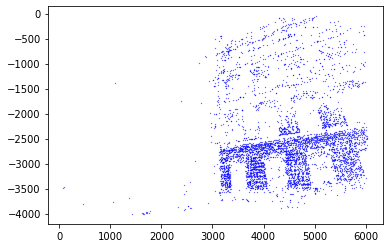

In [8]:
for img in images:
    print("Picture name: %s" %(img[0]))
    
    # Transforming image into np.array
    current_image = np.array(img[1])
    
    
    # Fiding data about our picture
    for i in images_info:
        if images_info[i].name == img[0]:
            image_data = images_info[i]
            break

    #data stored in camera_data
    for i in camera_info:
        if camera_info[i].id == image_data.camera_id:
            camera_data = camera_info[i]
    
    #extracting camera params
    fx, fy, cx, cy, k1, k2, p1, p2, k3, k4, sx1, sy1 = camera_data.params    
    
    for i,xys in enumerate(image_data.xys):
        
        # 1) If the z-coordinate of the point is smaller than or equal to zero, the point is unobserved.
        if image_data.point3D_ids[i] <= 0:
            continue
        else:
            pix_x, pix_y = int(xys[0]),int(xys[1])
            z_id = image_data.point3D_ids[i]
            for i in points_info:
                if z_id == points_info[i].id:
                    x, y, z = points_info[i].xyz
                    r, g, b = points_info[i].rgb
                    break
#         if z <= 0:
#                 new_image[pix_x][pix_y] = [r,g,b]
#             continue

#         print("Pixel location (%d,%d)"%(pix_x,pix_y))
#         current_image[pix_x][pix_y] = [r,g,b]

        # 2) Project the point onto the virtual image plane by dividing its x and y coordinates by its z coordinate,
        # resulting in the un-distorted x and y values (xd,yd)

        
        # Tranforming coordiantes from Global system
#         x,y,z = np.array([x, y, z]).dot(image_data.qvec2rotmat())
#         x,y,z = [x,y,z] + image_data.tvec
        
        x_d = x/z
        y_d = y/z

#         print("x_d: %f, y_d: %f" % (x_d,y_d))
        
        # 3) Apply the equidistant radial distortion model to get (ud,vd)
        
        rad = np.sqrt(x_d**2 + y_d**2)
        tao = np.arctan(rad)
        u_d = tao/rad * x_d
        v_d = tao/rad * y_d
        
# #         print('r: %f, tao: %f, ud: %f, vd: %f' %(r,tao,u_d,v_d))
        
#         # 4) Apply further distortion to get distorted normalized image coordinates (un,vn):
        
        t_r = 1 + k1*tao**2 + k2*tao**4 + k3*tao**6 + k4*tao**8
        
        u_n = u_d*t_r + 2*p1*(u_d*v_d) + p2*(tao**2 + 2*u_d**2) + sx1*tao**2
        v_n = u_d*t_r + 2*p2*(u_d*v_d) + p1*(tao**2 + 2*v_d**2) + sy1*tao**2
        
#         print('tr: %f,un: %f, vn: %f' %(t_r,u_n,v_n))
    
        # 5) Convert to pixel coordinates  (u,v):
        
        u = int(fx * u_n + cx)
        v = int(fy * v_n + cy)
#         u = int(fx * x_d+ cx)
#         v = int(fy * y_d + cy)
#         plt.plot(u,v,'r.', ms = 0.5)
        plt.plot(pix_x,-pix_y,'b.', ms = 0.5)
#         print("u: %d, v: %d"%(u,v))
        
        # this is not correct
        if camera_data.width > v and v >= 0 and u >=0 and camera_data.height > u:
            current_image[u][v] = [r,g,b]

#     undistorted_images.append(IMG.fromarray(new_image))
    plt.show()
    break